In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")

print("Path to dataset files:", path)

c:\Users\burha\.conda\envs\tf2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\burha\.cache\kagglehub\datasets\mohamedhanyyy\chest-ctscan-images\versions\1


In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", len(physical_devices))

for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


In [7]:
data_dir_train = f"{path}/Data/train"
data_dir_val = f"{path}/Data/valid"


train_data = image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(256,256),
    batch_size=16,
    shuffle=True
)

val_data = image_dataset_from_directory(
    data_dir_val,
    seed=123,
    image_size=(256,256),
    batch_size=16,
    shuffle=False
)

data_dir_test = f"{path}/Data/test"

test_data = image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(256,256),
    batch_size=16,
    shuffle=False
)


class_names = train_data.class_names
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#     tf.keras.layers.RandomRotation(0.3),
#     tf.keras.layers.RandomZoom(0.3)
# ])

# train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Ensure the datasets are one-hot encoded
train_data = train_data.map(lambda x, y: (x, tf.one_hot(y, depth=len(class_names))))
val_data = val_data.map(lambda x, y: (x, tf.one_hot(y, depth=len(class_names))))
test_data = test_data.map(lambda x, y: (x, tf.one_hot(y, depth=len(class_names))))

Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.


In [11]:
from keras.applications import VGG16, ResNet50, InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam


# Assuming you have train_data, test_data, valid_data loaded and preprocessed

# Function to create and compile a model
def create_model(base_model, num_classes):
  """Creates and compiles a model using a pre-trained base model."""
  base_model.trainable = False  # Freeze the base model's layers

  # Add new classification layers
  x = base_model.output
  x = GlobalAveragePooling2D()(x)  # Global average pooling
  outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

  # Create the final model
  model = Model(inputs=base_model.input, outputs=outputs)

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# 1. VGG16
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
vgg16_model = create_model(base_model_vgg16, num_classes=len(class_names))  # Use len(class_names)


# Train the model
vgg16_model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20
39/39 [==============================] - 17s 178ms/step - loss: 2.8553 - accuracy: 0.3051 - val_loss: 1.8385 - val_accuracy: 0.3333
Epoch 2/20
39/39 [==============================] - 4s 91ms/step - loss: 1.2388 - accuracy: 0.5351 - val_loss: 1.3299 - val_accuracy: 0.5000
Epoch 3/20
39/39 [==============================] - 4s 92ms/step - loss: 0.9314 - accuracy: 0.6313 - val_loss: 1.2210 - val_accuracy: 0.5694
Epoch 4/20
39/39 [==============================] - 4s 92ms/step - loss: 0.7181 - accuracy: 0.7031 - val_loss: 1.0949 - val_accuracy: 0.5972
Epoch 5/20
39/39 [==============================] - 4s 92ms/step - loss: 0.6213 - accuracy: 0.7374 - val_loss: 1.0590 - val_accuracy: 0.6250
Epoch 6/20
39/39 [==============================] - 4s 92ms/step - loss: 0.5450 - accuracy: 0.7814 - val_loss: 0.9886 - val_accuracy: 0.6806
Epoch 7/20
39/39 [==============================] - 4s 91ms/step - loss: 0.4729 - accuracy: 0.8238 - val_loss: 1.0274 - val_accuracy: 0.6528
Epoch 8/20


In [12]:
# Compile the model
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [13]:
# Train the model and store the training history
history = vgg16_model.fit(
    train_data,
    epochs=20,
    batch_size=32,
    validation_data=val_data
)

# Evaluate the model on the test set
test_accuracy = vgg16_model.evaluate(test_data, verbose=0)
print(f'Test accuracy: {test_accuracy[1]}')

# Save the model
vgg16_model.save('image_classification_model.h5')

Epoch 1/20
39/39 [==============================] - 4s 91ms/step - loss: 0.1896 - accuracy: 0.9511 - val_loss: 0.8147 - val_accuracy: 0.7778
Epoch 2/20
39/39 [==============================] - 4s 88ms/step - loss: 0.1762 - accuracy: 0.9543 - val_loss: 0.8468 - val_accuracy: 0.7639
Epoch 3/20
39/39 [==============================] - 3s 88ms/step - loss: 0.1564 - accuracy: 0.9641 - val_loss: 0.8728 - val_accuracy: 0.7361
Epoch 4/20
39/39 [==============================] - 4s 89ms/step - loss: 0.1344 - accuracy: 0.9690 - val_loss: 0.8654 - val_accuracy: 0.7500
Epoch 5/20
39/39 [==============================] - 4s 90ms/step - loss: 0.1180 - accuracy: 0.9772 - val_loss: 0.8661 - val_accuracy: 0.7500
Epoch 6/20
39/39 [==============================] - 3s 88ms/step - loss: 0.1113 - accuracy: 0.9853 - val_loss: 0.8395 - val_accuracy: 0.7778
Epoch 7/20
39/39 [==============================] - 4s 89ms/step - loss: 0.1164 - accuracy: 0.9837 - val_loss: 0.8386 - val_accuracy: 0.7639
Epoch 8/20
39

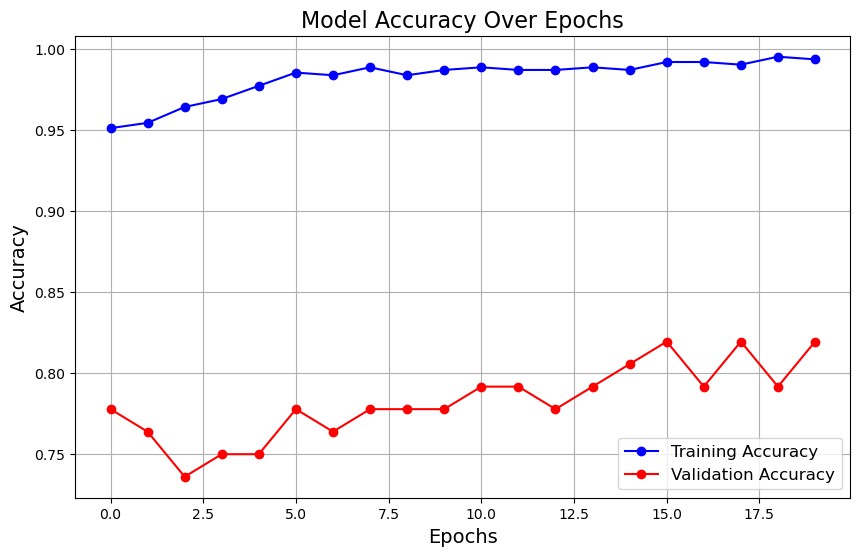

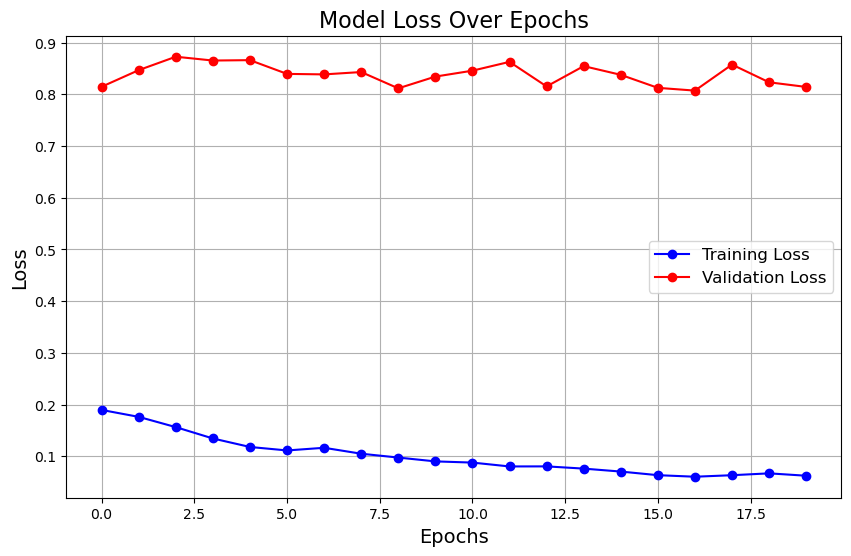

In [15]:
import matplotlib.pyplot as plt

# Plot the accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [16]:
# 2. ResNet50
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
resnet50_model = create_model(base_model_resnet50, num_classes=len(class_names))
resnet50_model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20
39/39 [==============================] - 5s 74ms/step - loss: 1.0710 - accuracy: 0.5188 - val_loss: 0.9821 - val_accuracy: 0.4861
Epoch 2/20
39/39 [==============================] - 2s 56ms/step - loss: 0.7205 - accuracy: 0.6868 - val_loss: 0.8367 - val_accuracy: 0.5972
Epoch 3/20
39/39 [==============================] - 2s 57ms/step - loss: 0.5913 - accuracy: 0.7618 - val_loss: 0.7849 - val_accuracy: 0.6111
Epoch 4/20
39/39 [==============================] - 2s 57ms/step - loss: 0.4732 - accuracy: 0.8271 - val_loss: 0.8358 - val_accuracy: 0.6250
Epoch 5/20
39/39 [==============================] - 2s 57ms/step - loss: 0.4007 - accuracy: 0.8825 - val_loss: 0.7031 - val_accuracy: 0.7083
Epoch 6/20
39/39 [==============================] - 2s 56ms/step - loss: 0.3586 - accuracy: 0.9005 - val_loss: 0.7460 - val_accuracy: 0.6667
Epoch 7/20
39/39 [==============================] - 2s 55ms/step - loss: 0.3033 - accuracy: 0.9364 - val_loss: 0.8371 - val_accuracy: 0.6250
Epoch 8/20
39

In [17]:
# Compile the model
resnet50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
resnet50_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [18]:
# Train the model and store the training history
history = resnet50_model.fit(
    train_data,
    epochs=20,
    batch_size=32,
    validation_data=val_data
)

# Evaluate the model on the test set
test_accuracy = resnet50_model.evaluate(test_data, verbose=0)
print(f'Test accuracy: {test_accuracy[1]}')

# Save the model
resnet50_model.save('image_classification_model.h5')

Epoch 1/20
39/39 [==============================] - 5s 74ms/step - loss: 0.1076 - accuracy: 0.9869 - val_loss: 0.5943 - val_accuracy: 0.7917
Epoch 2/20
39/39 [==============================] - 2s 54ms/step - loss: 0.0950 - accuracy: 0.9886 - val_loss: 0.5614 - val_accuracy: 0.8194
Epoch 3/20
39/39 [==============================] - 2s 54ms/step - loss: 0.0857 - accuracy: 0.9935 - val_loss: 0.6814 - val_accuracy: 0.7639
Epoch 4/20
39/39 [==============================] - 2s 54ms/step - loss: 0.0713 - accuracy: 0.9951 - val_loss: 0.5718 - val_accuracy: 0.7917
Epoch 5/20
39/39 [==============================] - 2s 55ms/step - loss: 0.0681 - accuracy: 0.9967 - val_loss: 0.6124 - val_accuracy: 0.7917
Epoch 6/20
39/39 [==============================] - 2s 54ms/step - loss: 0.0625 - accuracy: 0.9935 - val_loss: 0.5635 - val_accuracy: 0.8333
Epoch 7/20
39/39 [==============================] - 2s 54ms/step - loss: 0.0645 - accuracy: 0.9918 - val_loss: 0.5800 - val_accuracy: 0.8333
Epoch 8/20
39

In [19]:
# 3. InceptionV3
base_model_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
inceptionv3_model = create_model(base_model_inceptionv3, num_classes=len(class_names))
inceptionv3_model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20
39/39 [==============================] - 6s 79ms/step - loss: 8.7521 - accuracy: 0.3654 - val_loss: 3.9325 - val_accuracy: 0.4861
Epoch 2/20
39/39 [==============================] - 2s 50ms/step - loss: 2.6854 - accuracy: 0.5204 - val_loss: 1.9376 - val_accuracy: 0.5694
Epoch 3/20
39/39 [==============================] - 2s 50ms/step - loss: 2.0149 - accuracy: 0.5742 - val_loss: 1.8689 - val_accuracy: 0.5417
Epoch 4/20
39/39 [==============================] - 2s 51ms/step - loss: 1.5835 - accuracy: 0.6330 - val_loss: 1.3667 - val_accuracy: 0.6250
Epoch 5/20
39/39 [==============================] - 2s 52ms/step - loss: 1.0922 - accuracy: 0.6998 - val_loss: 1.8953 - val_accuracy: 0.6250
Epoch 6/20
39/39 [==============================] - 2s 52ms/step - loss: 1.1137 - accuracy: 0.7227 - val_loss: 1.7570 - val_accuracy: 0.5694
Epoch 7/20
39/39 [==============================] - 2s 50ms/step - loss: 1.5239 - accuracy: 0.6623 - val_loss: 1.1770 - val_accuracy: 0.6806
Epoch 8/20
39

In [20]:
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

inceptionv3_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [22]:
import os
import numpy as np
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import image_dataset_from_directory
from keras.applications import VGG16

# Define the data directory and image parameters
data_dir = '/kaggle/input/chest-ctscan-images/Data'
img_height, img_width = 128, 128  # Define your desired image size

# Data Loading and Preprocessing
def preprocess_data(dataset):
    """Applies preprocessing steps to the dataset."""
    return dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

# Get class names before preprocessing
class_names = train_data.class_names

# Apply preprocessing to all datasets
train_data = preprocess_data(train_data)
valid_data = preprocess_data(valid_data)
test_data = preprocess_data(test_data)

# Function to create and compile a model
def create_model(base_model, num_classes):
    """Creates and compiles a model using a pre-trained base model."""
    base_model.trainable = False  # Freeze the base model's layers

    # Add new classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global average pooling
    outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

    # Create the final model
    model = Model(inputs=base_model.input, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 1. VGG16
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
vgg16_model = create_model(base_model_vgg16, num_classes=len(class_names))

# Train the model and store the training history
history = vgg16_model.fit(
    train_data,
    epochs=20,
    batch_size=32,
    validation_data=valid_data
)

# Evaluate the model on the test set
test_accuracy = vgg16_model.evaluate(test_data, verbose=0)
print(f'Test accuracy: {test_accuracy[1]}')

# Save the model
vgg16_model.save('image_classification_model.h5')

# Summary of the model
vgg16_model.summary()

AttributeError: 'MapDataset' object has no attribute 'class_names'